In [6]:
import numpy as np
import pandas as pd
from pathlib import Path

from pyphoplacecellanalysis.PhoPositionalData.load_exported import import_mat_file
# from pyphoplacecellanalysis.PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from pyphoplacecellanalysis.PhoPositionalData.process_data import process_positionalAnalysis_data, extract_spike_timeseries

from neuropy.utils.dynamic_container import DynamicContainer

import sys
from threading import Thread

# pv.set_jupyter_backend('pythreejs')
# pv.set_jupyter_backend('ipygany') # ipygany fails " Failed to use notebook backend: "
# pv.set_jupyter_backend('panel') # Doesn't work either, produces no output
import numpy as np
import h5py
import hdf5storage # conda install hdf5storage

import ipywidgets as widgets

# import PhoPositionalData as pdp
# from pyphoplacecellanalysis.PhoPositionalData. import load_exported, process_data
from pyphoplacecellanalysis.PhoPositionalData.load_exported import *
# from pyphoplacecellanalysis.PhoPositionalData.process_data import process_positionalAnalysis_data, gen_2d_histrogram, get_heatmap_color_vectors, process_chunk_equal_poritions_data, extract_spike_timeseries
from pyphoplacecellanalysis.PhoPositionalData.process_data import *
from pyphoplacecellanalysis.PhoPositionalData.plot_data import *
from pyphoplacecellanalysis.PhoPositionalData.import_data import *

In [ ]:
## Drastically improve Python Tracebacks on exceptions:
# from rich.traceback import install
# install()

In [9]:
def build_spike_positions_list(spike_list, t, x, y):
    """Interpolate the positions that a spike occurred for each spike timestamp

    Args:
        spike_list ([type]): [description]
        t ([type]): [description]
        x ([type]): [description]
        y ([type]): [description]
    """
     # Determine the x and y positions each spike occured for each cell
    num_cells = len(spike_list)
    spike_positions_list = list()
    for cell_id in np.arange(num_cells):
        spike_positions_list.append(np.vstack((np.interp(spike_list[cell_id], t, x), np.interp(spike_list[cell_id], t, y))))
        # spike_positions_list.append(np.hstack(x[spike_list[cell_id]], y[spike_list[cell_id]]))
        # spike_speed = speeds[spike_list[cell_id]]
    return spike_positions_list

## TO REMOVE:
def build_cellID_reverse_lookup_map(cell_ids):
     # Allows reverse indexing into the linear imported array using the original cell ID indicies
    flat_cell_ids = [int(cell_id) for cell_id in cell_ids] # ensures integer indexes for IDs
    linear_flitered_ids = np.arange(len(cell_ids))
    return dict(zip(flat_cell_ids, linear_flitered_ids))


def perform_import_spikes(t, x, y, mat_import_parent_path=Path(r'C:\Share\data\RoyMaze1')):
    # Import the spikes
    # spikes_mat_import_file = mat_import_parent_path.joinpath('spikesTable.mat')
    spikes_mat_import_file = mat_import_parent_path.joinpath('ExportedData', 'spikesAnalysis.mat')
    spikes_data = import_mat_file(mat_import_file=spikes_mat_import_file)
    # print(spikes_data.keys())
    
    try:
        spike_matrix = spikes_data['spike_matrix']
        spike_cells = spikes_data['spike_cells'][0]
        cell_ids = spikes_data['spike_cells_ids'][:,0].T
        flat_cell_ids = [int(cell_id) for cell_id in cell_ids] 
    except KeyError as e:
        print(f'KeyError: {e}')
        print(f'\t Valid Keys: {list(spikes_data.keys())}')

    # print('spike_matrix: {}, spike_cells: {}'.format(np.shape(spike_matrix), np.shape(spike_cells)))
    num_cells = np.shape(spike_matrix)[0]
    # extract_spike_timeseries(spike_cells[8])
    spike_list = [extract_spike_timeseries(spike_cell) for spike_cell in spike_cells]
    # print(spike_list[0])
    
#     print('np.shape(cell_ids): {}, cell_ids: {}'.format(np.shape(cell_ids), cell_ids))
    # Determine the x and y positions each spike occured for each cell
    spike_positions_list = build_spike_positions_list(spike_list, t, x, y)    
#     print(np.shape(spike_positions_list[0])) # (2, 9297)
    
     # reverse_cellID_idx_lookup_map: Allows reverse indexing into the linear imported array using the original cell ID indicies
    reverse_cellID_idx_lookup_map = build_cellID_reverse_lookup_map(cell_ids)

    return spike_matrix, spike_cells, num_cells, spike_list, spike_positions_list, flat_cell_ids, reverse_cellID_idx_lookup_map

def perform_import_positions(mat_import_parent_path=Path(r'C:\Share\data\RoyMaze1')):
    position_mat_import_file = mat_import_parent_path.joinpath('ExportedData','positionAnalysis.mat')
    data = import_mat_file(mat_import_file=position_mat_import_file)

    # # KevinMaze1
    # mat_import_file = 'data/Kevin-maze1/PreFinalBinningResultWholeEnv.mat'
    # data = import_mat_file(mat_import_file=mat_import_file)
    # # 'spikeStruct'
    # # 'speed','t','v' # 3243057×1

    # # Achilles:
    # main_data_path = Path(r'C:\Users\Pho\repos\PhoPy3DPositionAnalysis2021\data\Achilles_10252013')
    # positionFilename = main_data_path.joinpath('ExportedData', 'Achilles_10252013_position.mat')
    # positionFileFullpath = main_data_path.joinpath(positionFilename) # build a full filepath from the basepath
    # data = import_mat_file(mat_import_file=positionFileFullpath)
    # # print('data:'.format(data.keys()))
    # data
    # Get the position data:
    t,x,y,speeds,dt,dx,dy = process_positionalAnalysis_data(data)
    print('shapes - t: {}, x: {}, y: {}'.format(np.shape(t), np.shape(x), np.shape(y))) 
    # extrema_min, extrema_max = np.nanmin(x), np.nanmax(x)
    # print('for x: extrema_min: {}, extrema_max: {}'.format(extrema_min, extrema_max))
    # extrema_min, extrema_max = np.nanmin(y), np.nanmax(y)
    # print('for y: extrema_min: {}, extrema_max: {}'.format(extrema_min, extrema_max))
    return t,x,y,speeds,dt,dx,dy


def perform_import_extras(mat_import_parent_path=Path(r'C:\Share\data\RoyMaze1')):
    extras_mat_import_file = mat_import_parent_path.joinpath('ExportedData','extrasAnalysis.mat')
    #source_data.behavior.RoyMaze1.list
    all_results_data = import_mat_file(mat_import_file=extras_mat_import_file)
 #   behavioral_periods = all_results_data['behavioral_periods_table']
    behavioral_periods = all_results_data['behavioral_periods']
    behavioral_epochs = all_results_data['behavioral_epochs']
    
    ## Convert the loaded dicts to dataframes:
    behavioral_epochs = pd.DataFrame(all_results_data['behavioral_epochs'], columns=['epoch_index','start_seconds_absolute','end_seconds_absolute','start_seconds','end_seconds','duration'])
    #['pre_sleep','track','post_sleep']    
    behavioral_periods = pd.DataFrame(all_results_data['behavioral_periods'], columns=['period_index','epoch_start_seconds','epoch_end_seconds','duration','type','behavioral_epoch'])
    return behavioral_periods, behavioral_epochs



# def perform_import_extras(mat_import_parent_path=Path(r'C:\Share\data\RoyMaze1')):
# """

# Usage:
#     ripple_times, ripple_peak_times, ripple_peak_values, behavioral_periods, behavioral_epochs = perform_import_extras(mat_import_parent_path=mat_import_parent_path)

#     # behavioral_periods = all_results_data['active_processing/behavioral_periods_table']
#     # print('spike_matrix: {}, spike_cells: {}'.format(np.shape(spike_matrix), np.shape(spike_cells)))
#     num_periods = np.shape(behavioral_periods)[0]
#     print('num_periods: {}'.format(num_periods))

# """
#     extras_mat_import_file = mat_import_parent_path.joinpath('ExportedData','extrasAnalysis.mat')
    
#     ripple_mat_import_file = mat_import_parent_path.joinpath('ExportedData', 'RippleManualExport.h5')
#     #periods_mat_import_file = mat_import_parent_path.joinpath('ExportedData\BehavioralPeriodsManualExport.h5')
#     periods_mat_import_file = mat_import_parent_path.joinpath('ExportedData', 'extrasAnalysis.mat')
    
#     #source_data.behavior.RoyMaze1.list
    
#     ripple_data = import_mat_file(mat_import_file=ripple_mat_import_file)
#     ripple_times = ripple_data['time']
#     ripple_peak_times = ripple_data['peakTime']
#     ripple_peak_values = ripple_data['peakVal']
    
#     all_results_data = import_mat_file(mat_import_file=periods_mat_import_file)
#  #   behavioral_periods = all_results_data['behavioral_periods_table']
#     behavioral_periods = all_results_data['behavioral_periods']
#     behavioral_epochs = all_results_data['behavioral_epochs']
    
#     behavioral_epochs = pd.DataFrame(all_results_data['behavioral_epochs'], columns=['epoch_index','start_seconds_absolute','end_seconds_absolute','start_seconds','end_seconds','duration'])
    
#     #['pre_sleep','track','post_sleep']
    
#     behavioral_periods = pd.DataFrame(all_results_data['behavioral_periods'], columns=['period_index','epoch_start_seconds','epoch_end_seconds','duration','type','behavioral_epoch'])
    
#     return ripple_times, ripple_peak_times, ripple_peak_values, behavioral_periods, behavioral_epochs

In [13]:
# from sorcery import dict_of

def load_position_spikes_extras_mats(parent_path=r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze1'):
    mat_import_parent_path = Path(parent_path)
    
    # Import the positions
    t,x,y,speeds,dt,dx,dy = perform_import_positions(mat_import_parent_path=mat_import_parent_path)
    pos_vars = DynamicContainer(t=t,x=x,y=y,speeds=speeds,dt=dt,dx=dx,dy=dy)
    
    # Import the spikes
    spike_matrix, spike_cells, num_cells, spike_list, spike_positions_list, flat_cell_ids, reverse_cellID_idx_lookup_map = perform_import_spikes(t, x, y, mat_import_parent_path=mat_import_parent_path)
    spikes_vars = DynamicContainer(spike_matrix=spike_matrix, spike_cells=spike_cells, num_cells=num_cells, spike_list=spike_list, spike_positions_list=spike_positions_list, flat_cell_ids=flat_cell_ids, reverse_cellID_idx_lookup_map=reverse_cellID_idx_lookup_map)
    
    behavioral_periods, behavioral_epochs = perform_import_extras(mat_import_parent_path=mat_import_parent_path)
    # behavioral_periods = all_results_data['active_processing/behavioral_periods_table']
    # print('spike_matrix: {}, spike_cells: {}'.format(np.shape(spike_matrix), np.shape(spike_cells)))
    num_periods = np.shape(behavioral_periods)[0]
    print('num_periods: {}'.format(num_periods))
    extras_vars = DynamicContainer(behavioral_periods=behavioral_periods, behavioral_epochs=behavioral_epochs, num_periods=num_periods)
    all_vars = DynamicContainer(pos=pos_vars, spikes=spikes_vars, extras=extras_vars)
    return all_vars
    
    
# RoyMaze1:
# mat_import_parent_path = Path(r'R:\data\RoyMaze1')
mat_import_parent_path = Path(r'R:\rMBP Python Repos 2022-07-07\PhoNeuronGillespie2021CodeRepo\PhoMatlabDataScripting\ExportedData\RoyMaze1')
# mat_import_parent_path = Path(r'C:\Share\data\RoyMaze1') # Old one
# mat_import_file = r'C:\Share\data\RoyMaze1\ExportedData.mat'
all_vars = load_position_spikes_extras_mats(parent_path=mat_import_parent_path)
all_vars

NameError: name 'ripple_times' is not defined

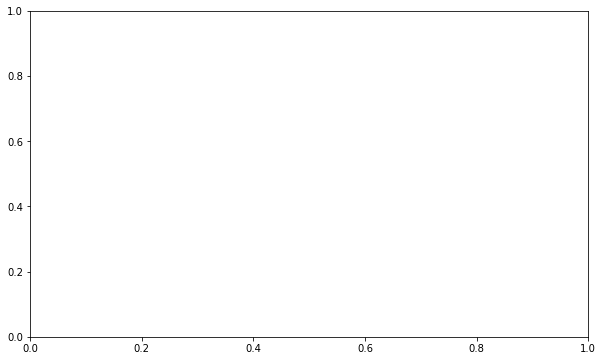

In [14]:
# creating the dataset
#date = [i for i in range(2000, 2021)]
 
# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))
 
# Creating the scatter plot
#ax.scatter(date, value)
 
# Highlighting for a certain period of time
num_ripples = np.shape(ripple_times)[0]
for i in np.arange(num_ripples):
    ax.axvspan(ripple_times[i,0], ripple_times[i,1], alpha=0.3, color="green")

plt.show()

In [ ]:
## IDEA: Define a series of fallback options for each variable using the command chain pattern.

